# Classifying Even and Odd Numbers with a Convolutional Neural Network


This is a convolutional neural network built in PyTorch that recognizes whether an integer in a sequence is odd or even. 

** The problem: ** 

Assume that we have a sequence of $n$ integers between 0 and 99 (inclusive) such that no two consecutive numbers are odd. The goal is to create a NN using convolutions such that for each sequence it predicts if the parity of the numbers. For example:

[10,11,12,2] $\to$ [Even,Odd,Even, Even]

Here is a simple function that does this in a "classical way" (No need of NN, or any machine learning). [1,0] means even, [0,1] means odd

In [2]:
def find_parity(seq):
    for number in seq:
        if number % 2 == 0:
            yield [1,0]
        else:
            yield [0,1]
            
list(find_parity([10,11,12,2]))

[[1, 0], [0, 1], [1, 0], [1, 0]]

But to PyTorch, we will make a convolutional neural network that does the same thing. 

## Part 1 - Creating the data

The goal for this section is to create a class designed to generate our data. 

In [3]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.functional import tanh, softmax

In [4]:
class DataGenerator(object):
    """Generates sequences of integers following the rules
    
    Attributes:
        nb_samples: Number of samples to generate.
        sq_length: The length of each sample/sequence.
        split: Percentages of data to be split into training, validation, and testing.
        train_X: training features
        train_Y: training labels
        val_X: validation features
        val_Y: validation labels
        test_X: testing features
        test_Y: testing labels
    """   
    
    def __init__(self, size = 1000, sequence_length = 10 ): 
        self.nb_samples = size
        self.sq_length = sequence_length
        self.split = [50.0,25.0,25.0]
        self.__build_data()
        
    def __build_data(self):
        x_data = []
        y_data = []
        
#       generating data - sequences of integers between 0 and 99 where there are no two consecutive odd numbers
        for i in range(self.nb_samples):
            sequence = []
            for j in range(self.sq_length):
                if (j != 0) and (sequence[j-1]%2):
                    temp = np.random.randint(0,100)
                    while temp%2:
                        temp = np.random.randint(0,100)
                    sequence.append(temp)
                else:
                    sequence.append(np.random.randint(0,100))
            x_data.append(sequence)
            y_data.append(list(find_parity(sequence)))
                
        
        a = int(self.nb_samples*(self.split[0]/100.0))
        b = int(self.nb_samples*(self.split[1]/100.0))
        
        self.train_X = Variable(torch.from_numpy(np.array(x_data[:a])), requires_grad = False)
        self.train_Y = Variable(torch.from_numpy(np.array(y_data[:a])), requires_grad = False).double()
        
        self.val_X = Variable(torch.from_numpy(np.array(x_data[a:a+b])), requires_grad = False)
        self.val_Y = Variable(torch.from_numpy(np.array(y_data[a:a+b])), requires_grad = False).double()
        
        self.test_X = Variable(torch.from_numpy(np.array(x_data[a+b:])), requires_grad = False)
        self.test_Y = Variable(torch.from_numpy(np.array(y_data[a+b:])), requires_grad = False).double()
        

In [5]:
dataGenerator = DataGenerator(1000, 10)

## Part 2 - Building the model

Now that we have our data, we can build the model. We go with the following architecture:

Embedding layer **-->** convolution layer **-->** activation function **-->** fully connected layer. 

In [6]:
class Net(torch.nn.Module):
    
    def __init__(self, num_conv=1):
        super(Net, self).__init__()
        self.num_conv = num_conv
        
#       embedding layer - 100 embeddings because the integers are between 0 and 99 (inclusive)
        self.emb = torch.nn.Embedding(100,1)
    
#       convolution layer - kernel size of 3  
        self.conv = torch.nn.Conv1d(1, self.num_conv, 3, bias = False)
    
#       fully connected layer needs to have output size 2 (to compare with [1,0] or [0,1])
        self.fully_connected = torch.nn.Linear(num_conv,2)
        
    def forward(self,x):
#       needs to end with size 50x10x2
        x = self.emb(x)
        x = x.transpose(2,1)
        
#       add padding so that first and last few integers are still considered
        x = torch.nn.ConstantPad1d(1,0.)(x)
        x = self.conv(x)
        x = tanh(x)
        x = x.transpose(2,1)
        x = self.fully_connected(x)
        return softmax(x, dim=1)
        

In [7]:
net = Net(20).double()

In the next step we create an optimizer

In [8]:
optimizer = torch.optim.Adam(net.parameters())

## Part 3 - Training the model

We define some parameters for the training.

In [9]:
counter = 0
losses = []
val_losses = []
epochs = 2000
embeddings = np.zeros([200,100])

We now go over the training phase

In [10]:
X = dataGenerator.train_X
y = dataGenerator.train_Y
X_val = dataGenerator.val_X
y_val = dataGenerator.val_Y

for i in range(epochs):
    
    if i%10==0:
        embeddings[i//10,:] = net.state_dict()['emb.weight'].numpy().T[0]
    counter+=1
        
    y_pred=net(X)

    optimizer.zero_grad()
    loss = ((y_pred - y)**2).mean()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.numpy())
    
    y_pred_val = net(X_val)
    val_loss = ((y_pred_val- y_val)**2).mean()
    val_losses.append(val_loss)
    
    print("Epoch %d of %d. Current step is %d with loss %.2f "%(i+1,epochs,counter,loss.data.numpy()), end="\r")

We plot the training loss and validation loss.

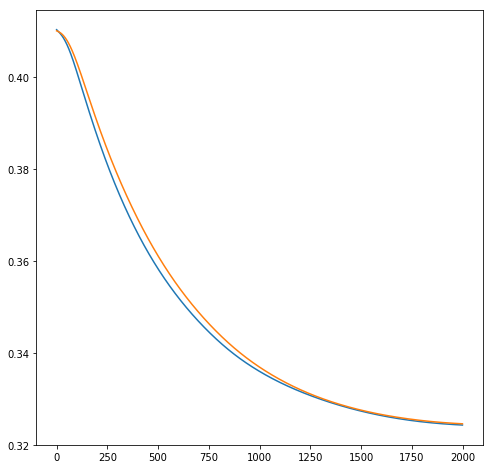

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(losses)
plt.plot(val_losses)
plt.show()

Our first goal is to understand the embeddings, so let's trace what happens with the embedding values of the first 10 integers.

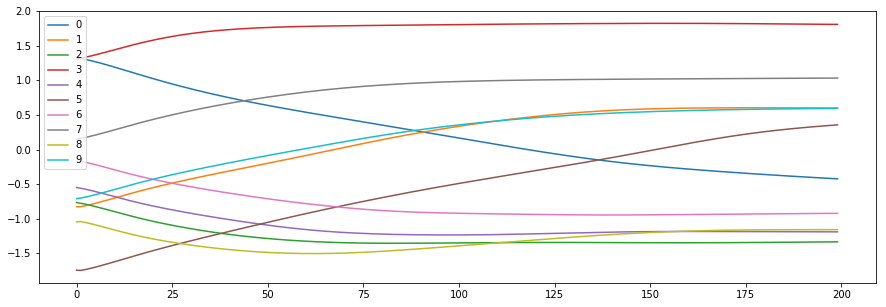

In [13]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(embeddings[:,i],label = "%d"%i)
plt.legend()
plt.show()

So, it seems that all even numbers took larger values than all the odd numbers. 

Next, we proceed to analyze the convolutions. We can see a pattern where odd numbers output something closer to [0,1], whereas even numbers are closer to [1,0].

In [14]:
test = Variable(torch.from_numpy(np.random.randint(0,100, size = (3,10))), requires_grad = False)
print(dataGenerator.test_X)
net(dataGenerator.test_X)

tensor([[  1,  84,  13,  ...,  25,  56,  16],
        [ 25,  34,  75,  ...,  21,  46,  29],
        [ 77,  96,  78,  ...,  68,  46,  76],
        ...,
        [ 31,  42,  82,  ...,  77,  16,  93],
        [ 57,  84,  55,  ...,  96,   0,   4],
        [ 27,  56,  62,  ...,  25,  14,  29]])


tensor([[[ 2.7885e-04,  2.4576e-01],
         [ 1.9178e-01,  9.0585e-06],
         [ 2.5394e-04,  2.4947e-01],
         ...,
         [ 2.6011e-04,  2.5597e-01],
         [ 1.9348e-01,  9.9193e-06],
         [ 8.1032e-02,  1.7725e-04]],

        [[ 2.8334e-04,  2.5099e-01],
         [ 2.1351e-01,  9.4234e-06],
         [ 3.2977e-04,  1.9569e-01],
         ...,
         [ 2.8439e-04,  2.3183e-01],
         [ 2.0695e-01,  8.3121e-06],
         [ 6.9799e-04,  8.2566e-02]],

        [[ 1.7916e-04,  5.0051e-01],
         [ 1.1699e-01,  2.0293e-05],
         [ 1.4838e-01,  2.4362e-04],
         ...,
         [ 1.2218e-01,  2.2375e-05],
         [ 1.2746e-01,  1.2716e-04],
         [ 1.1851e-01,  4.7217e-05]],

        ...,

        [[ 1.9469e-04,  3.5664e-01],
         [ 1.4094e-01,  1.2166e-05],
         [ 1.5370e-01,  2.3558e-04],
         ...,
         [ 2.1979e-04,  3.0711e-01],
         [ 1.2641e-01,  1.5257e-05],
         [ 2.1551e-04,  3.3554e-01]],

        [[ 2.9643e-04,  3.0662e-01

That's it! Credits to Felipe Perez for coming up with the problem.